In [437]:
import os
import sys
import importlib
import glob
import time
from tqdm import tqdm

import torch
import numpy as np
import matplotlib.pyplot as plt
from src.RationalApproximation import RationalApproximation_AAA
from scipy.special import gamma 
import scipy
import pandas as pd 

In [318]:

#########################################
### Time Integrators   
#########################################

class ModesImplicitEuler: 
    def __init__(self, poles, weights, **kwargs):
        self.poles = poles
        self.weights = weights

    # u_k^n+1 = alpha_k u_k^n + beta_k u^n+1 + gamma_k u^n     
    def get_coefficients(self, dt): 
        alphas = 1 / (1 + dt * self.poles)
        betas = (dt * self.weights) / (1 + dt * self.poles)
        gammas = 0 * self.poles

        # print(alphas.shape, betas.shape, gammas.shape)
        return alphas, betas, gammas 

class ModesCrankNicolson: 

    def __init__(self, poles, weights):
        self.poles = poles
        self.weights = weights

    # u_k^n+1 = alpha_k u_k^n + beta_k u^n+1 + gamma_k u^n     
    def get_coefficients(self,dt): 
        denom = (1 + 0.5 * dt * self.poles)

        alphas = (1 - 0.5 * dt * self.poles)   / denom
        betas  = 0.5 * dt * self.weights / denom 
        gammas = 0.5 * dt * self.weights / denom 

        return alphas, betas, gammas  

class ModesExponentialIntegrator: 

    def __init__(self, poles, weights):
        self.poles = poles
        self.weights = weights

    # u_k^n+1 = alpha_k u_k^n + beta_k u^n+1 + gamma_k u^n     
    def get_coefficients(self,dt): 
        alphas = np.exp(- self.poles * dt)
        betas  = self.weights * (alphas - (1 - self.poles * dt)) / (dt * self.poles ** 2)
        gammas = self.weights * (1 - (1 + self.poles * dt) * alphas) / (dt * self.poles ** 2)
        return alphas, betas, gammas  


class ModesBlendedLinearMultistepMethod: 

    def __init__(self, poles, weights):
        self.kappa = 1 
        self.poles = poles
        self.weights = weights
        

    # u_k^n+1 = alpha_k u_k^n + beta_k u^n+1 + gamma_k u^n     
    def get_coefficients(self,dt): 
        denom = (1 
                 + self.kappa * self.poles * dt 
                 + self.kappa * self.poles ** 2 * dt ** 2
                 + 0.5 * self.poles * dt)

        alphas = (1 
                  - 0.5 * self.poles * dt 
                  + self.kappa * self.poles * dt) / denom 
        betas  = (0.5 * self.weights * dt 
                  + self.kappa * self.poles * self.weights * dt ** 2) / denom 
        gammas = (0.5 * dt * self.weights) / denom 
        return alphas, betas, gammas  



In [319]:
class MultiTermKernel: 

    def __init__(self, phis, alphas, **kwargs):
        self.phis = phis
        self.alphas = alphas

        self.RATarget = np.vectorize(self.eval_RATarget) 
        self.kernel = np.vectorize(self.eval_kernel)

    def eval_kernel(self, t):
        return np.sum(self.phis / gamma(1 - self.alphas) * t **(-self.alphas))
    
    def eval_RATarget(self, t):
        return np.sum(self.phis * t ** (1 - self.alphas))
    
# Distribution phi 
@np.vectorize
def Distribution(alpha): 
    return gamma(6 - alpha) / 120

# Right side of the equation 
@np.vectorize
def f(t): 
    if t == 0: 
        return 0
    if t == 1: 
        return 2
    return (t ** 5 - t**3) / np.log(t)

# Analytical solution 
@np.vectorize
def sol_u(t): 
    return t ** 5

@np.vectorize
def sol_v(t): 
    return 5 * t**4 

# Analytical solution modes 
@np.vectorize
def sol_modes(t, a, w): 
    # w = weights 
    # a = poles 
    # the constant is chosen such that the modes have initial condition u_k(0)=0
    c = 120 * w / a ** 6 
    return (w * (- 120        / a**6 
                 + 120 * t**1 / a**5 
                 - 60  * t**2 / a**4 
                 + 20  * t**3 / a**3 
                 - 5   * t**4 / a**2 
                 + 1   * t**5 / a) 
                 + c * np.exp(-a*t))

In [323]:
#########################################
### Quadrature of the integral 
#########################################

n_QF = 2 ** 15

# interval length / (n for 0 to 1 + n for 1 to 2 + 3 for 0,1,2)
QFweight = 2 / (2*n_QF+3)
quadraturePoints01 = np.arange(0 + 0.5/n_QF,1 + 0.5/n_QF, 1/n_QF)
quadraturePoints12 = np.arange(1 + 0.5/n_QF,2 + 0.5/n_QF, 1/n_QF)

phis01 = Distribution(quadraturePoints01) * QFweight
phis12 = Distribution(quadraturePoints12) * QFweight
phi0 = Distribution(0) * QFweight
phi1 = Distribution(1) * QFweight
phi2 = Distribution(2) * QFweight

MTK01 = MultiTermKernel(phis01,quadraturePoints01)
MTK12 = MultiTermKernel(phis12,quadraturePoints12-1)


In [375]:
#########################################
### Simulation and error  
#########################################

# dts = [1e-2 * 2 ** (-i) for i in range(11)]
dts = [0.1,0.01,0.001,0.0001, 0.00001]

error_u = [] 
error_v = []

u_list = []
v_list = []
a_list = []

# error_modes01 = np.zeros((len(dts), m01))
# error_modes12 = np.zeros((len(dts), m12))

print("Minimal time step:", dts[-1])    

for idx, dt in enumerate(dts): 

    n_timesteps = int(np.round(T/dt)) + 1
    t = dt * np.asarray(range(n_timesteps))   

    #########################################
    ### Rational Approximation of the Integral Kernel
    #########################################

    T  = 1
    Zmin, Zmax = 1/T,1/dt
    tol = 1.e-10
    MaxDegree = 30
    nSupportPoints = 100

    RA01 = RationalApproximation_AAA(alpha=0.5, tol=tol, MaxDegree=MaxDegree, nSupportPoints=nSupportPoints, Zmin= Zmin, Zmax= Zmax, verbose=False, 
                                    TargetFunction=MTK01.RATarget)
    RA12 = RationalApproximation_AAA(alpha=0.5, tol=tol, MaxDegree=MaxDegree, nSupportPoints=nSupportPoints, Zmin= Zmin, Zmax= Zmax, verbose=False, 
                                    TargetFunction=MTK12.RATarget)

    weights01 = RA01.c
    poles01 = RA01.d
    winf01 = RA01.c_inf
    m01 = weights01.shape[0]

    weights12 = RA12.c
    poles12 = RA12.d
    winf12 = RA12.c_inf
    m12 = weights12.shape[0]

    #########################################
    ### Numerical Scheme 
    #########################################

    beta0 = phi0 + np.sum(weights01) - np.sum(weights12 * poles12)
    beta1 = phi1 + np.sum(weights12) + winf01
    beta2 = phi2 + winf12

    modes01 = np.zeros((n_timesteps, m01)) 
    modes12 = np.zeros((n_timesteps, m12)) 

    u = np.zeros(n_timesteps) 
    v = np.zeros(n_timesteps) 
    a = np.zeros(n_timesteps) 

    # Initial conditions if necessary 
    u[0] = 0
    v[0] = 0 
    a[0] = 0

    # TIModes01 = ModesCrankNicolson(poles01, weights01) 
    # TIModes12 = ModesCrankNicolson(poles12, weights12) 

    TIModes01 = ModesExponentialIntegrator(poles01, weights01) 
    TIModes12 = ModesExponentialIntegrator(poles12, weights12) 

    # TIModes01 = ModesImplicitEuler(poles01, weights01) 
    # TIModes12 = ModesImplicitEuler(poles12, weights12) 

    alphas01, betas01, gammas01 = TIModes01.get_coefficients(dt)
    alphas12, betas12, gammas12 = TIModes12.get_coefficients(dt)

    # Implicit first order time integration 
    a0 = dt/2
    a1 = dt/2

    a0 = 0
    a1 = dt

    print("dt:", dt)
    
    # Time loop 
    for n in tqdm(range(n_timesteps-1), ncols=100): 

        M = (- np.sum(poles01 * gammas01) * u[n] 
             + np.sum(poles12 ** 2 * gammas12) * u[n]
             - np.sum(poles01 * alphas01 * modes01[n])
             + np.sum(poles12 ** 2 * alphas12 * modes12[n]))
        
        A = beta0 - np.sum(poles01 * betas01) + np.sum(poles12**2 * betas12)

        a[n+1] = -1 / (A * dt**2/4 + beta1 * dt/2 + beta2) * (A * (u[n] + dt * v[n] + dt**2/4 *a[n]) + beta1*(v[n] + dt/2*a[n]) + M - f((n+1)*dt))
        v[n+1] = v[n] + dt/2 * (a[n] + a[n+1])
        u[n+1] = u[n] + dt * v[n] + dt**2/4 * (a[n] + a[n+1])

        # # correct 
        # A = (- a0 * beta0 
        #         - a1 * beta0 
        #         + np.sum(a1 * poles01 * (betas01 + gammas01)) 
        #         - np.sum(a1 * poles12 ** 2 * (betas12 + gammas12))) / beta2

        # # correct 
        # B = 1 + (- a0 * beta1 
        #             - a0 * a1 * beta0 
        #             + np.sum(a0 * a1 * poles01 * betas01) 
        #             - np.sum(a0 * a1 * poles12 ** 2 * betas12)) / beta2
        
        # # correct  
        # C = a1 / beta2 * (- a1 * beta0 
        #                     - beta1 
        #                     + np.sum(a1 * poles01 * betas01) 
        #                     - np.sum(a1 * poles12 ** 2 * betas12))

        # tmp = (a0 / beta2 * f(n * dt) 
        #     + a1 / beta2 * f((n+1)*dt) 
        #     + A * u[n] + B * v[n] 
        #     + np.sum((a0 + a1 * alphas01) * poles01 * modes01[n]) / beta2  
        #     - np.sum((a0 + a1 * alphas12) * poles12 **2 * modes12[n]) / beta2)
    
        # v[n+1] = tmp / (1-C)
        # u[n+1] = u[n] + dt * v[n+1]

        modes01[n+1] = alphas01 * modes01[n] + betas01 * u[n+1] + gammas01 * u[n] 
        modes12[n+1] = alphas12 * modes12[n] + betas12 * u[n+1] + gammas12 * u[n] 

    #########################################
    ### Compute error 
    #########################################

    u_list.append(u)
    v_list.append(v)
    a_list.append(a)

    error_u.append(dt * (np.linalg.norm(sol_u(t) - u)))
    error_v.append(dt * (np.linalg.norm(sol_v(t) - v)))

    # for i in range(m01): 
    #     error_modes01[idx, i] = dt * (np.linalg.norm(modes01[:,i] - sol_modes(t, poles01[i], weights01[i])))
        
    # for i in range(m12): 
    #     error_modes12[idx, i] = dt * (np.linalg.norm(modes12[:,i] - sol_modes(t, poles12[i], weights12[i])))
    

Minimal time step: 1e-05
dt: 0.1


100%|████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10607.75it/s]


dt: 0.01


100%|██████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 11884.24it/s]


dt: 0.001


100%|████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 13805.09it/s]


dt: 0.0001


100%|██████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 13246.21it/s]


dt: 1e-05


100%|████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 13172.65it/s]


In [377]:
t

array([0.0000e+00, 1.0000e-05, 2.0000e-05, ..., 9.9998e-01, 9.9999e-01,
       1.0000e+00])

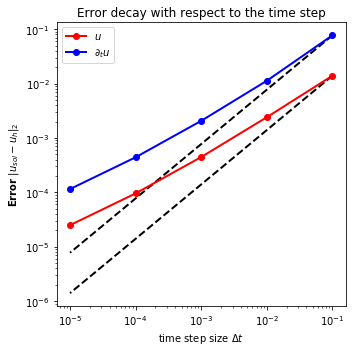

In [376]:
#########################################
### Visualization  
##########################################

fig,ax = plt.subplots(figsize = (5,5))
ax.set_title("Error decay with respect to the time step")
ax.loglog(dts, np.asarray(dts) * np.max(error_u) / np.max(dts), color = "black", linewidth = 2, linestyle="--")
ax.loglog(dts, np.asarray(dts) * np.max(error_v) / np.max(dts), color = "black", linewidth = 2, linestyle="--")
ax.loglog(dts, error_u, color = "red", linewidth = 2, marker="o", label = r"$u$")
# ax.loglog(dts[:-1], error_u_num[:-1], color = "red", linewidth = 2, marker="+", label = r"$u$")
ax.loglog(dts, error_v, color = "blue", linewidth = 2, marker="o", label = r"$\partial_t u$")
# ax.loglog(dts[:-1], error_v_num[:-1], color = "blue", linewidth = 2, marker="+", label = r"$\partial_t u$")
ax.set_xlabel(r'time step size $\Delta t$') 
ax.set_ylabel(r"Error $\|u_{sol} - u_h\|_2$", fontweight ='bold')
ax.legend() 
plt.tight_layout()
plt.savefig("ErrorDecayNewmarkEI.pdf")

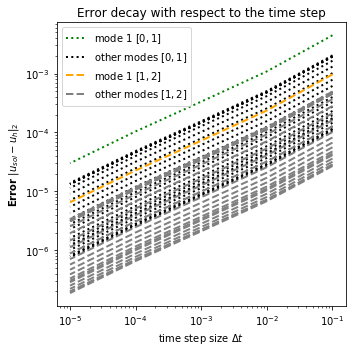

In [371]:
fig,ax = plt.subplots(figsize = (5,5))
ax.set_title("Error decay with respect to the time step")
ax.loglog(dts, error_modes01[:,1:], color = "black", linewidth = 2, linestyle=":")
ax.loglog(dts, error_modes01[:,0], color = "green", linewidth = 2, linestyle=":", label = r"mode 1 $[0,1]$")
ax.loglog(dts, error_modes01[:,1], color = "black", linewidth = 2, linestyle=":", label = r"other modes $[0,1]$")
ax.loglog(dts, error_modes12[:,1:], color = "grey", linewidth = 2, linestyle="--")
ax.loglog(dts, error_modes12[:,0], color = "orange", linewidth = 2, linestyle="--", label = r"mode 1 $[1,2]$")
ax.loglog(dts, error_modes12[:,1], color = "grey", linewidth = 2, linestyle="--", label = r"other modes $[1,2]$")
ax.set_xlabel(r'time step size $\Delta t$') 
ax.set_ylabel(r"Error $\|u_{sol} - u_h\|_2$", fontweight ='bold')
ax.legend() 
plt.tight_layout()

In [316]:
poles12

array([1.87810033e-02, 4.74947328e-01, 1.80837925e+00, 5.15780757e+00,
       1.34433194e+01, 3.40691210e+01, 8.56429020e+01, 2.14210184e+02,
       5.35137600e+02, 1.34674642e+03, 3.43280732e+03, 8.83764708e+03,
       2.28187040e+04, 5.89866871e+04, 1.53484696e+05, 4.04704505e+05,
       1.08592059e+06, 2.96774486e+06, 8.30831309e+06, 2.45550455e+07,
       8.47290200e+07, 5.19021920e+08])

In [300]:
weights12

array([0.04768726, 0.0230534 , 0.02782359, 0.04078158, 0.06797423,
       0.13092231, 0.33233864, 1.87965766])